In [21]:
metrics = ['Voice','SMS_3G','PS','CS','Call','SMS_4G','Service_Req','HO']


# original data 



#ExpectedAnomaliesFile = "20211005_DiscretExpectedAnomalies.csv"


# Lyon configuration
#SourceParquetFilesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Lyon/'
#MedianParquetFilesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Lyon_meds_OriginalSplit_fillna/'
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Lyon_detection_OriginalSplit_AllMetrics_6Thresh/"
#ParquetFilesSignaturesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Lyon_sigs_OriginalSplit_AllMetrics'
#CsvFilesThresholdsLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Lyon_Thresholds_OriginalSplit_AllMetrics_6Thresh.csv'
#AntennasLocInfosFile = "/rapids/notebooks/LICIT_COMMON_Folder/LICIT_INPUT/notebooks/notebooks_pierre/exports/Cancan_Lyon_LocInfos_Summarized.csv"




# Paris configuration, 6 thresholds, original split, Voice and SMS fusion (4 variables)
SourceParquetFilesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris/'
MedianParquetFilesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_meds_OriginalSplit_fillna/'
AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_VoiceSMS_6Thresh/"
ParquetFilesSignaturesLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_sigs_2'
CsvFilesThresholdsLoc = '/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_Thresholds_OriginalSplit_VoiceSMS_6Thresh.csv'
AntennasLocInfosFile = "/rapids/notebooks/LICIT_COMMON_Folder/LICIT_INPUT/notebooks/notebooks_pierre/exports/Cancan_Paris_LocInfos_Summarized.csv"




#Cancan2022_Lyon_Thresholds_OriginalSplit_AllMetrics_6Thresh.csv
#Cancan2022_Lyon_Thresholds_OriginalSplit_CallSMS_6Thresh.csv 
#Cancan2022_Lyon_detection_OriginalSplit_AllMetrics_6Thresh
#Cancan2022_Lyon_detection_OriginalSplit_CallSMS_6Thresh
#Cancan2022_Lyon_distribs_OriginalSplit_AllMetrics_6Thress
#Cancan2022_Lyon_distribs_OriginalSplit_CallSMS_6Thresh
#Cancan2022_Lyon_meds_OriginalSplit_fillna
#Cancan2022_Lyon_sigs_OriginalSplit_AllMetrics
#Cancan2022_Lyon_sigs_OriginalSplit_CallSMS       



# Incendie de Notre Dame values
LocIdsOfInterest = [789, 849]

# dates to start the extraction of data from
ExtractDateStart = "2019-04-15T18:00:00"
ExtractDateEnd = "2019-04-15T20:00:00"

VerticalTimestampLines = ["2019-04-15T18:50:00", "2019-04-15T18:58:00", "2019-04-15T19:10:00"]




# Manifestation du premier mai values
#LocIdsOfInterest = [934, 453, 911]

# dates to start the extraction of data from
#ExtractDateStart = "2019-05-01T11:30:00"
#ExtractDateEnd = "2019-05-01T19:30:00"

#VerticalTimestampLines = ["2019-05-01T11:55:00", "2019-05-01T15:21:00", "2019-05-01T17:44:00", "2019-05-01T19:00:00"]









# to switch from 6 levels to 3 levels
#LevelReplacement is used as newLevel = LevelReplacements[oldLevel]
LevelReplacements = [0, 1, 1, 2, 2, 2, 3]

#ThresholdsReplacement is used as : NewThreshold[i] = OldThreshold[ThresholdsReplacement[i]]
ThresholdsReplacement = [0, 2, 5]

AnomColors = ['darkgreen', 'goldenrod', 'darkorange', 'firebrick']





In [22]:
from datetime import datetime, timedelta, date, timezone
from dateutil import tz

import pyspark
import pyspark.sql.functions as f
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.types import *


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import json

from shapely.geometry import shape, Point, Polygon


import geopy.distance


import warnings
warnings.filterwarnings('ignore')

import sys



In [23]:
NUMBER_OF_THREADS_TO_USE = "*"
spark = SparkSession.builder \
    .master('local[' + NUMBER_OF_THREADS_TO_USE + ']') \
    .appName('discret_JsonAlertsGeneration') \
    .config('spark.driver.memory', '200g') \
    .config('spark.driver.maxResultSize', '30g') \
    .config('spark.rapids.sql.enabled','true') \
    .getOrCreate()
sc = spark.sparkContext


spark.conf.set("spark.sql.session.timeZone", "Europe/Paris")




spark

In [24]:


# found how to navigate between weeks here
# https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar

def iso_year_start(iso_year):
    #"The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime(iso_year, 1, 4, 0, 0, 0, tzinfo=tz.gettz("Europe/Paris"))
    delta = timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    #"Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + timedelta(days=iso_day-1, weeks=iso_week-1)


# framacalc seems to use excel format for dates
# so here's the conversion tool according to: https://www.semicolonworld.com/question/56907/how-to-convert-a-given-ordinal-number-from-excel-to-a-date

def from_excel_ordinal(ordinal, _epoch0=datetime(1899, 12, 31)):
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + timedelta(days=ordinal)).replace(microsecond=0)



TestWeeksGroupsList = [ [11,12,13,14,15], [16,17,18,19], [20,21,22,23,24] ]

CorrespondingGroup = [None]*25
for grp in range(0,len(TestWeeksGroupsList)):
    for w in TestWeeksGroupsList[grp]:
        CorrespondingGroup[w] = grp



In [25]:
# load source data
DetectionsSparkDF = spark.read.parquet(AlertsSourceParquetFile)
DetectionsSparkDF.printSchema()

# load source data
MediansDFSP = spark.read.parquet(MedianParquetFilesLoc)
MediansDFSP.printSchema()

#only keep the median
for m in metrics:
    MediansDFSP = MediansDFSP.withColumn(m, MediansDFSP[m].getItem(1))
    
MediansDFSP.printSchema()


# now, order antennas according to their known position
AntennasLocInfosDF = pd.read_csv(AntennasLocInfosFile)
print(AntennasLocInfosDF.info(verbose=True))


OriginalDataDFSP = spark.read.parquet(SourceParquetFilesLoc)
OriginalDataDFSP.printSchema()


SignaturesDFSP = spark.read.parquet(ParquetFilesSignaturesLoc)
SignaturesDFSP.printSchema()

ThresholdsDF = pd.read_csv(CsvFilesThresholdsLoc)
print(ThresholdsDF.info(verbose=True))



root
 |-- MinuteWithinWeek: long (nullable = true)
 |-- WeeksGroup: long (nullable = true)
 |-- LocationId: long (nullable = true)
 |-- ALR: double (nullable = true)
 |-- Anomaly_Level: long (nullable = true)
 |-- WeekOfYear: integer (nullable = true)



root
 |-- MinuteWithinWeek: integer (nullable = true)
 |-- Voice: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- SMS_3G: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- PS: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- CS: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- Call: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- SMS_4G: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- Service_Req: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- HO: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- VoicePlusCall: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- WeeksGroup: integer (nullable = true)
 |-- LocationId: integer (nullable = true)

root
 |-- MinuteWithinWeek: integer (nullable = true)
 |-- Voice: long (nullable = true)
 |-- SMS_3G: long (nullabl

root
 |-- time_utc: string (nullable = true)
 |-- time_local: timestamp (nullable = true)
 |-- Voice: long (nullable = true)
 |-- PS: long (nullable = true)
 |-- SMS_3G: long (nullable = true)
 |-- CS: long (nullable = true)
 |-- Service_Req: long (nullable = true)
 |-- Call: long (nullable = true)
 |-- SMS_4G: long (nullable = true)
 |-- HO: long (nullable = true)
 |-- MinuteWithinWeek: integer (nullable = true)
 |-- WeeksGroup: integer (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- LocationId: integer (nullable = true)



root
 |-- MinuteWithinWeek: long (nullable = true)
 |-- Voice: double (nullable = true)
 |-- SMS_3G: double (nullable = true)
 |-- PS: double (nullable = true)
 |-- CS: double (nullable = true)
 |-- Call: double (nullable = true)
 |-- SMS_4G: double (nullable = true)
 |-- Service_Req: double (nullable = true)
 |-- HO: double (nullable = true)
 |-- WeeksGroup: integer (nullable = true)
 |-- LocationId: integer (nullable = true)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3078 entries, 0 to 3077
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WeeksGroup         3078 non-null   int64  
 1   LocationId         3078 non-null   int64  
 2   level1byPL6Thresh  3078 non-null   float64
 3   level2byPL6Thresh  3078 non-null   float64
 4   level3byPL6Thresh  3078 non-null   float64
 5   level4byPL6Thresh  3078 non-null   float64
 6   level5byPL6Thresh  3078 non-null   float64
 7   level6byPL6Thresh  3078 n

In [26]:
# know on which weeks and Location Ids we have performed the detection
LocIdsList = sorted([x.LocationId for x in DetectionsSparkDF.select('LocationId').distinct().collect()])
print("found " + str(len(LocIdsList)) + " location groups")
print(LocIdsList)

WeekIdsList = sorted([x.WeekOfYear for x in DetectionsSparkDF.select('WeekOfYear').distinct().collect()])
print("found " + str(len(WeekIdsList)) + " different weeks")
print(WeekIdsList)


AnomalyLevelsList = sorted([x.Anomaly_Level for x in DetectionsSparkDF.select('Anomaly_Level').distinct().collect()])
print("found " + str(len(AnomalyLevelsList)) + " different Anomaly levels")
print(AnomalyLevelsList)



found 1026 location groups
[4, 5, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 173, 174, 175, 177, 179, 180, 183, 184, 186, 187, 188, 189, 191, 192, 193, 195, 196, 197, 198, 201, 202, 203, 204, 205, 206, 207, 208, 212, 213, 214, 215, 217, 218, 219, 220, 221, 222, 225, 226, 227, 229, 231, 232, 233, 235, 236, 237, 238, 241, 243, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 265, 268, 269

found 7 different Anomaly levels
[0, 1, 2, 3, 4, 5, 6]


In [27]:
# get the date range values from a given event

tdBeginning = datetime.strptime(ExtractDateStart, "%Y-%m-%dT%H:%M:%S")
ScheduleWeekBeginning = tdBeginning.isocalendar()[1]
#print(ScheduleWeekBeginning)
#then the corresponding time and date for minute 0 of this week
FirstWeekDayBeginning = datetime.combine(iso_to_gregorian(2019,ScheduleWeekBeginning,1), datetime.min.time())

# Now find the corresponding minute of our event
MinuteWithinWeekBeginning = int(round((tdBeginning-FirstWeekDayBeginning).total_seconds() / 60))
#print(MinuteWithinWeekBeginning)

tdEnding = datetime.strptime(ExtractDateEnd, "%Y-%m-%dT%H:%M:%S")
ScheduleWeekEnding = tdEnding.isocalendar()[1]
#print(ScheduleWeekEnding)
#then the corresponding time and date for minute 0 of this week
FirstWeekDayEnding = datetime.combine(iso_to_gregorian(2019,ScheduleWeekEnding,1), datetime.min.time())

# Now find the corresponding minute of our event
MinuteWithinWeekEnding = int(round((tdEnding-FirstWeekDayEnding).total_seconds() / 60))
#print(MinuteWithinWeekEnding)


def FindTestingWeeksGroup(week):
    for tg in range(0,len(TestWeeksGroupsList)):
        for wTest in TestWeeksGroupsList[tg]:
            if wTest==week:
                return tg




# build the list of intervals in our time representation
ListTimeIntervals = []

# simplest case: the end week is the same as the beginning week
if ScheduleWeekBeginning == ScheduleWeekEnding:
    # add +1 because we want to include the minute
    ListTimeIntervals.append({'Week':ScheduleWeekBeginning, 'MinutesStart':MinuteWithinWeekBeginning, 'MinutesEnd':MinuteWithinWeekEnding+1, 'WeeksGroup':FindTestingWeeksGroup(ScheduleWeekBeginning)})
elif ScheduleWeekBeginning < ScheduleWeekEnding:
    # consecutive weeks, almost as simple
    # first to the end of the first week
    ListTimeIntervals.append({'Week':ScheduleWeekBeginning, 'MinutesStart':MinuteWithinWeekBeginning, 'MinutesEnd':7*24*60, 'WeeksGroup':FindTestingWeeksGroup(ScheduleWeekBeginning)})
    
    # if there are weeks in between, just add all the minutes
    for w in range(ScheduleWeekBeginning+1, ScheduleWeekEnding):
        ListTimeIntervals.append({'Week':w, 'MinutesStart':0, 'MinutesEnd':7*24*60, 'WeeksGroup':FindTestingWeeksGroup(w)})
    
    # then from the beginning of the second one
    ListTimeIntervals.append({'Week':ScheduleWeekEnding, 'MinutesStart':0, 'MinutesEnd':MinuteWithinWeekEnding+1, 'WeeksGroup':FindTestingWeeksGroup(ScheduleWeekEnding)})
else:
    print("there is a mistake, the ending date is anterior to the beginning date")
    
print("intervals we want to extract:")
print(ListTimeIntervals)

TotalTimeExpected = 0
for lti in ListTimeIntervals:
    TotalTimeExpected += lti['MinutesEnd']-lti['MinutesStart']
    
print("Total extraction time: " + str(TotalTimeExpected))

intervals we want to extract:
[{'Week': 16, 'MinutesStart': 1080, 'MinutesEnd': 1201, 'WeeksGroup': 1}]
Total extraction time: 121


In [28]:

# no filter on the LocIds, this is too expensive
# however we can try a filter on the anomaly level


#ExportSparkDF = DetectionsSparkDF.filter(DetectionsSparkDF.Anomaly_Level>=MinAlertLevel)
#ExportSparkDF = DetectionsSparkDF
ExportSparkDF = DetectionsSparkDF.filter(DetectionsSparkDF.LocationId.isin(LocIdsOfInterest))
#for i in range(1,len(LocIdsOfInterest)):
#    LocId = LocIdsOfInterest[i]
#    ExportSparkDF = ExportSparkDF.union(DetectionsSparkDF.filter(DetectionsSparkDF.LocationId==LocId))
    

    
    

locsTable = [None] * (max(LocIdsList)+1)
#print(len(locsTable))


# so we just keep the group IDs and the corresponding WGS84 coords
AntennasGroupsList = list(AntennasLocInfosDF.groupby(['LAT', 'LON', 'LocationId']).groups)

rejectList = []


for agl in AntennasGroupsList:
    if agl[2] not in LocIdsOfInterest:
        # don't record antennas on which we have nothing - probably no data at all in the original dataset although they are referenced
        #rejectList.append(agl[2])
        continue
    locsTable[agl[2]] = {"lat":agl[0], "lon":agl[1]}



    
    
# this is the list of dictionnary objects where we store the recorded dicts
TotalDetectsDictsList = []


#with tqdm(total=TotalTimeExpected, desc='Minutes Extraction') as pbar:


# store the WeeksGroup, we assume that there is a single one in the time interval
# set a default value, then modify it while running through the intervals

WeeksGroup = 0


for lti in ListTimeIntervals:
    week = lti['Week']
    MinutesRange = range(lti['MinutesStart'],lti['MinutesEnd'])
    WeeksGroup = lti['WeeksGroup']

    WeekTime = datetime.combine(iso_to_gregorian(2019,week,1), datetime.min.time(), tzinfo=tz.gettz("Europe/Paris"))
    WeekDetectionsSparkDF = ExportSparkDF.filter((ExportSparkDF.WeekOfYear==week) & (ExportSparkDF.MinuteWithinWeek>=lti['MinutesStart']) & (ExportSparkDF.MinuteWithinWeek<=lti['MinutesEnd']))

    WeekDetectionsSparkDF.printSchema()
    
    for lid in LocIdsOfInterest:
    
        WeekDetectionsPDF = WeekDetectionsSparkDF.filter(WeekDetectionsSparkDF.LocationId==lid).orderBy(f.col('MinuteWithinWeek').asc()).drop('WeekOfYear').drop('WeeksGroup').toPandas()
        WeekDetectionsPDF['Anomaly_Level'] = WeekDetectionsPDF['Anomaly_Level'].fillna(0).astype('int')
        WeekDetectionsPDF['LocationId'] = WeekDetectionsPDF['LocationId'].fillna(0).astype('int')

        PreviousAnomLevel = 0

        for index, row in WeekDetectionsPDF.iterrows():
            CurrentTime = WeekTime + timedelta(minutes=row['MinuteWithinWeek'])
            TimeStampStr = CurrentTime.isoformat()

            NewEntry = { '@timestamp': CurrentTime,
                          'method': 'Signatures',
                          'LocId': int(row['LocationId']),
                          'location_lat': locsTable[int(row['LocationId'])]['lat'],
                          'location_lon': locsTable[int(row['LocationId'])]['lon'],
                          'Anomaly_Level': LevelReplacements[int(row['Anomaly_Level'])],
                          'ALR_value': -row['ALR'],
                          'Prev_Anomaly_Level': PreviousAnomLevel
                        }

            TotalDetectsDictsList.append(NewEntry)

            PreviousAnomLevel = LevelReplacements[int(row['Anomaly_Level'])]

    #pbar.update(1)

    #continue


#print("writing the json file...")
    
#print(TotalDetectsDictsList)
#with open('exports/20211018_DiscretDetectedAnomalies_GJMayFirst.json', 'w', encoding='utf8') as json_file:
#    json.dump(TotalDetectsDictsList, json_file, ensure_ascii=False)      


print("converting to pandas dataframe...")
    
DetectionsPdf = pd.DataFrame(TotalDetectsDictsList)
DetectionsPdf.set_index('@timestamp', inplace=True)
#pdf.to_csv(OutputDetectionsFile, index=False)

#print("... csv file has been written")







root
 |-- MinuteWithinWeek: long (nullable = true)
 |-- WeeksGroup: long (nullable = true)
 |-- LocationId: long (nullable = true)
 |-- ALR: double (nullable = true)
 |-- Anomaly_Level: long (nullable = true)
 |-- WeekOfYear: integer (nullable = true)

converting to pandas dataframe...


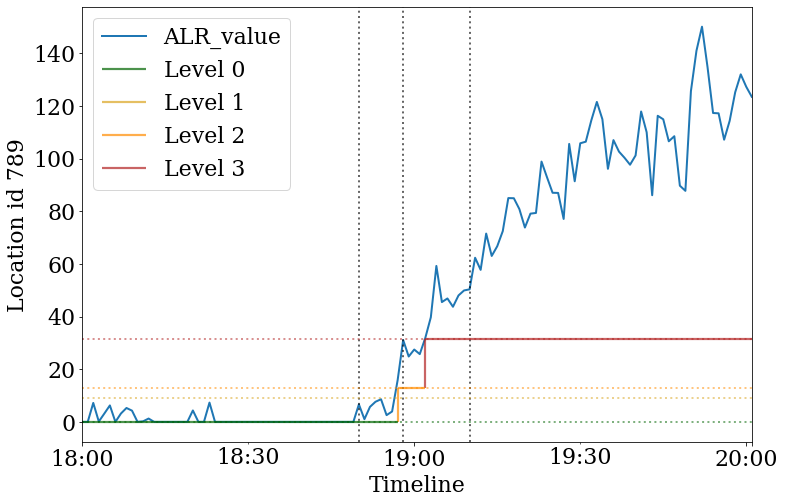

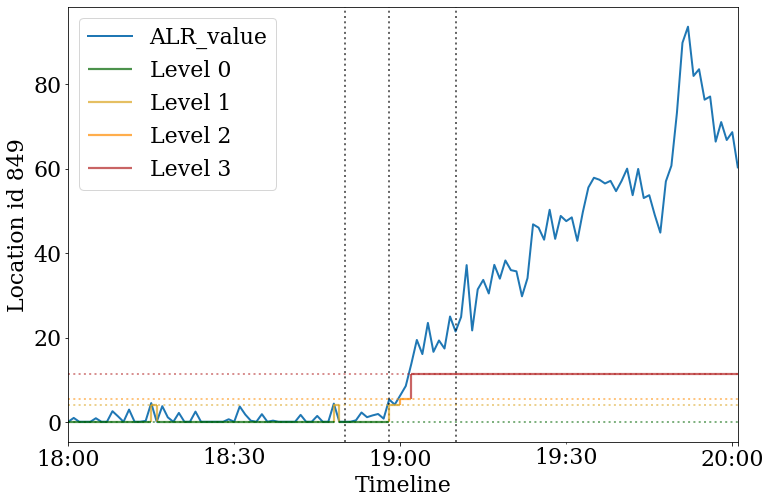

In [33]:
#DetectionsPdf.info(verbose=True)

#displayMetrics = ['Anomaly_Level', 'ALR_value']
displayMetrics = ['ALR_value']

#plt.style.use('default')

plt.rcParams.update({'font.size': 22, 'font.family':'serif'})


VlineTimes = []
for vl in VerticalTimestampLines:
    VlineTimes.append(datetime.strptime(vl, "%Y-%m-%dT%H:%M:%S"))


for CurrentLID in LocIdsOfInterest:
    axxx = DetectionsPdf[DetectionsPdf['LocId']==CurrentLID].plot(y=displayMetrics[0], figsize=(12,8), lw=2, alpha=1, xlabel="Timeline", ylabel="Location id " + str(CurrentLID), label=displayMetrics[0])
    
    for m in displayMetrics[1:]:
        DetectionsPdf[DetectionsPdf['LocId']==CurrentLID].plot(y=m, alpha=0.8, ax=axxx, label=m, lw=2)

        
    for vl in VlineTimes:
        axxx.axvline(x=vl, color='black', ls=':', alpha=0.6, lw=2)

    DispThreshValuesDF = ThresholdsDF[(ThresholdsDF['LocationId']==CurrentLID) & (ThresholdsDF['WeeksGroup']==WeeksGroup)].drop(columns=['WeeksGroup', 'LocationId'])
    tmpThreshList = DispThreshValuesDF.values.tolist()[0]
    DispThreshValues = [0.]
    for ti in ThresholdsReplacement:
        DispThreshValues.append(tmpThreshList[ti])

        
        
        
    VLinesDF = DetectionsPdf[(DetectionsPdf['LocId']==CurrentLID) & (DetectionsPdf['Prev_Anomaly_Level']!=DetectionsPdf['Anomaly_Level'])].reset_index()
    #VLinesDF.info(verbose=True)
    
    VLinesValues = []
    VLinesMin = []
    VLinesMax = []
    
    for ti in range(0, len(DispThreshValues)):
        VLinesValues.append([])
        VLinesMin.append([])
        VLinesMax.append([])
    
    for index, row in VLinesDF.iterrows():
        minLevel = row['Anomaly_Level']
        maxLevel = row['Prev_Anomaly_Level']
        if row['Anomaly_Level']>row['Prev_Anomaly_Level']:
            minLevel = row['Prev_Anomaly_Level']
            maxLevel = row['Anomaly_Level']

        VLinesMin[maxLevel].append(-DispThreshValues[minLevel])
        VLinesMax[maxLevel].append(-DispThreshValues[maxLevel])
        VLinesValues[maxLevel].append(row['@timestamp'])

    
    for ti in range(0, len(VLinesValues)):
        #print(VLinesMin[ti])
        axxx.vlines(x=VLinesValues[ti], ymin=VLinesMin[ti], ymax=VLinesMax[ti], colors=AnomColors[ti], lw=2.2, alpha=0.7 )
    
    
    for ti in range(0, len(DispThreshValues)):
        axxx.axhline(y=-DispThreshValues[ti], color=AnomColors[ti], linestyle=':', alpha=0.5, linewidth=2)
        
        LevelTimeLineDF = DetectionsPdf[(DetectionsPdf['LocId']==CurrentLID) & (DetectionsPdf['Anomaly_Level']==ti)].reset_index()
        
        HLinesValues = []
        HLinesMins = []
        HLinesMax = []
        
        for index, row in LevelTimeLineDF.iterrows():
            HLinesValues.append(-DispThreshValues[ti])
            HLinesMins.append(row['@timestamp'])
            HLinesMax.append(row['@timestamp'] + timedelta(minutes=1))
        
        axxx.hlines(y=HLinesValues, xmin=HLinesMins, xmax=HLinesMax, colors=AnomColors[ti], lw=2.2, alpha=0.7, label='Level ' + str(ti))
        
        
        #LevelTimeLineDF.plot(y='thresh', alpha=0.8, ax=axxx, label='Level ' + str(ti+1), color=AnomColors[ti])
        #break
        
    axxx.legend()
        
        
    